# Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import os
import sys
import cv2

### As per assignement define a Function to initialise the mean and variance matrice as follows.
### M1(x, y, k) = I1(x, y, k) {Used First Image}
### V1(x, y, k) = vd  Here vd is selected as 9

In [2]:
def initBackground(initImage):
    img_arr = mpimg.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)
    return(mean,variance)

### In the given assignment : Difference Image => Dt(x, y, k) = It(x, y, k) −Mt−1(x, y, k) while foreground and background classification is based on Chebyshev inequality, So below is a function defined to detect the foreground

In [3]:
def ForegroundDetection(img_file,mean,variance,lmda):
    img = mpimg.imread(img_file) 
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return(rI)

# Below function perform noise removal in mxm neighborhood;pixel is declared foreground if the fraction exceeds a certain threshhold : Formula given in assignment is implemented below.

In [4]:
def Voting(rI,eta,m,n):
    r,c = rI.shape
    cI = np.zeros((rI.shape[0],rI.shape[1]))
    for i in range(m,r-1-m):
        for j in range(n,c-1-n):
            img_patch = rI[i-m:i,j-n:j]
            y_unq, counts = np.unique(img_patch,return_counts=True)
            if len(counts) == 1 and y_unq[0] == 1:
                cI[i,j] = 255
            if len(counts)>1:
                if counts[1] > eta*m*n:
                    cI[i,j] = 255
    cI = cI.astype(np.uint8)
    return cI

# Background Model update (only for background that too using voted image)

In [5]:
def meanvarUpdate(cI,img_path,M,V,alpha):
    img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:] + alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:] + alpha*d_2[i,j,:])
                var_upd[i,j,:] = np.clip(var_upd[i,j,:],a_min = 9,a_max = None)
    return(mean_upd,var_upd)

In [6]:
def Background_Subtraction(img_dir,lmda,eta,m,n,alpha):
    
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir,img_file_name[0])
    mean, variance = initBackground(initImage)
    
    for i in range(1,len(img_file_name)):
        img_path = os.path.join(img_dir,img_file_name[i])
        
        fig, ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)
        ax[1].imshow(cI,cmap="gray")
        
        img = mpimg.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()
        

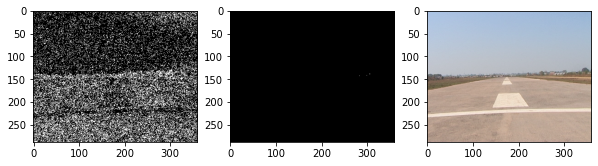

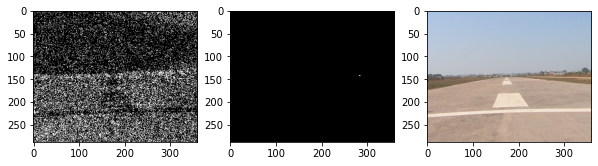

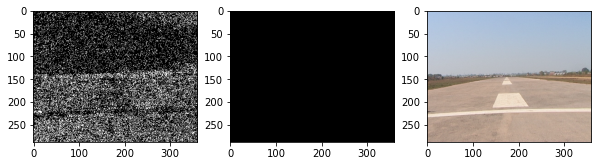

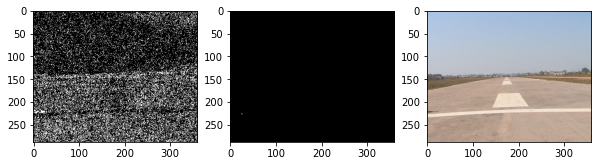

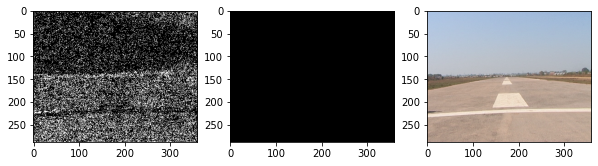

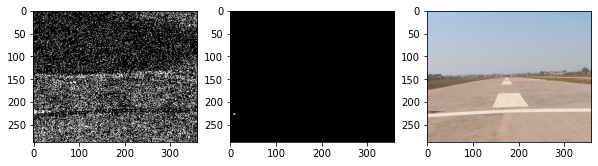

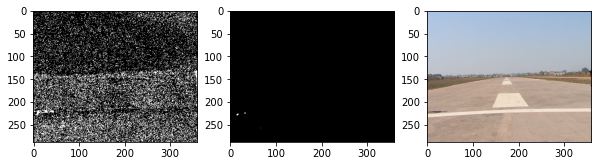

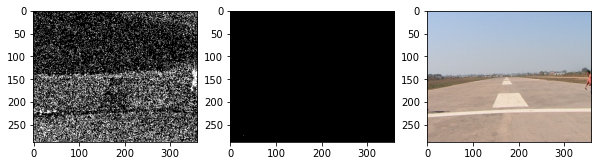

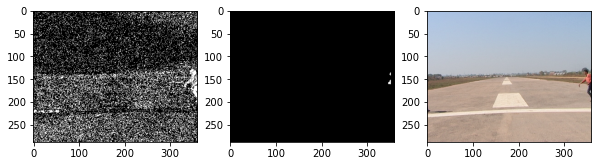

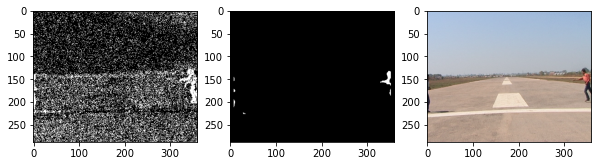

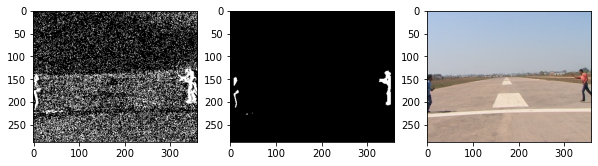

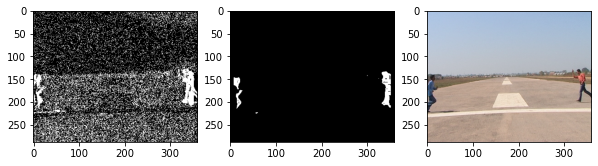

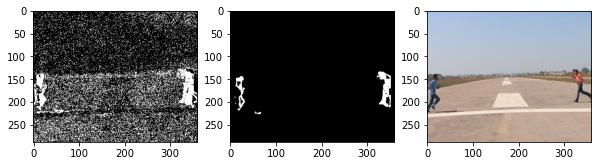

In [7]:
# Fine tuned parameters
# Due to time constraints only first 14 images are shown, but it works fine for all the images
Background_Subtraction(img_dir = "./Images",lmda=0.8,eta=0.7,m=8,n=8,alpha=0.8)

### Report sensitivity and false alarm rate for given parameters; first see the results using these parameters

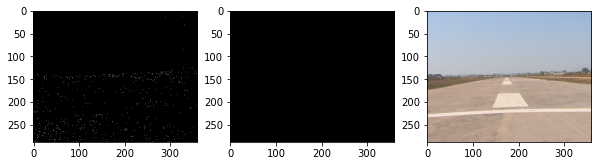

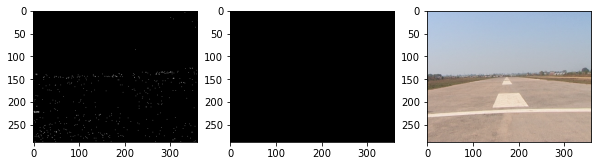

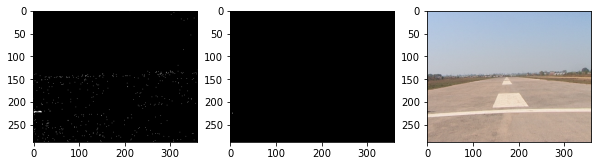

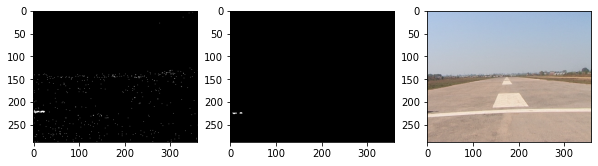

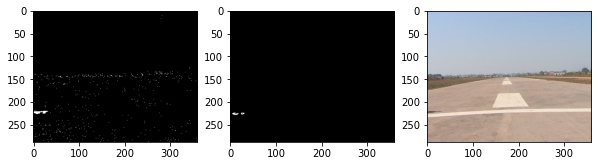

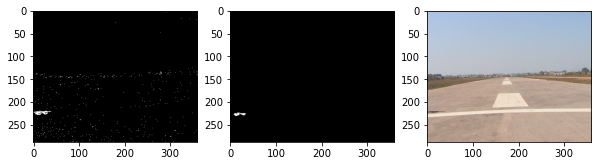

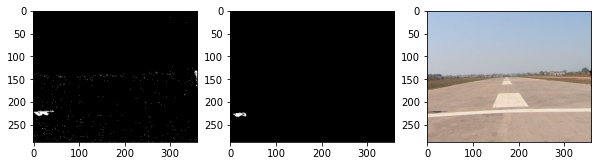

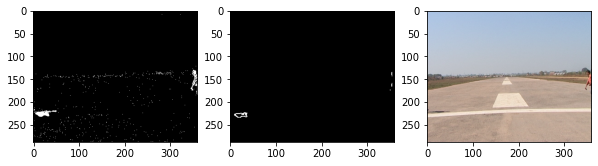

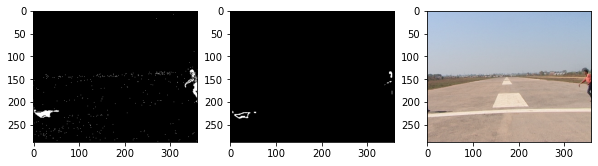

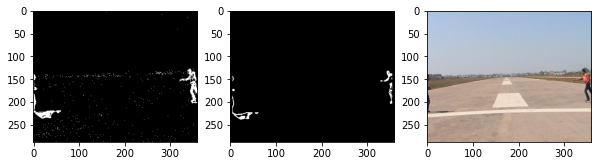

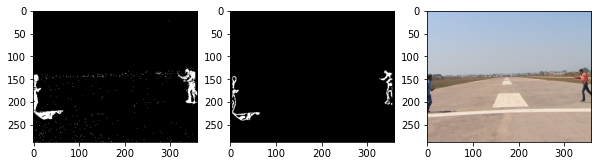

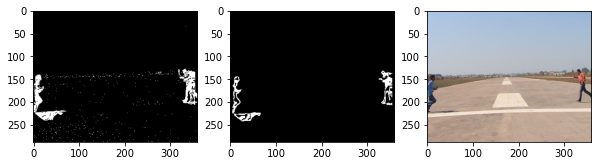

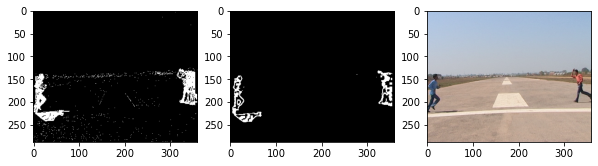

In [8]:
# Due to time constraints only first 14 images are shown, but it works fine for all the images
variance = 9
lmbda = 3.0
m=5
n=5
eta = 0.6
alpha = .01
#Background_Subtraction(img_dir,lmda,eta,m,n,alpha)
Background_Subtraction(img_dir="./Images",lmda=3,eta=0.6,m=5,n=5,alpha=0.01)

### FalseAlarm

In [9]:
# As per ground truth images, first six images have no foreground 
# while with the given parameters in assignment only 3 imgaes have no foreground
# Hence there will be false alarm for 4th , 5th ,6th image


# Livestream

In [11]:
def initBackground_Live(initImage):
    mean = initImage
    variance = 9*np.ones(initImage.shape)
    return(mean,variance)

In [12]:
def ForegroundDetection_Live(img,mean,variance,lmda):
#     img = mpimg.imread(img_file) 
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return(rI)

In [13]:
def meanvarUpdate_Live(cI,img,M,V,alpha):
#     img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:] + alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:] + alpha*d_2[i,j,:])
                var_upd[i,j,:] = np.clip(var_upd[i,j,:],a_min = 9,a_max = None)
    return(mean_upd,var_upd)

In [14]:
def Background_Subtraction_Live(img,lmda,eta,m,n,alpha,mean_live,variance_live):
   
    rI = ForegroundDetection_Live(img,mean_live,variance_live,lmda)
    cI = Voting(rI,eta,m,n)
    mean, variance = meanvarUpdate_Live(cI,img,mean_live,variance_live,alpha)
    return cI,mean,variance

In [15]:
# It is working however it is very slow, I need to wait for almost 1 min to see another frame. Not sure what is the reason.
#May be there is some silly mistake.

cap = cv2.VideoCapture(0);
ret, img = cap.read();
mean_live,variance_live = initBackground_Live(img)
while(1): 
    # read frames 
    ret, img = cap.read(); 
    cI,mean_new,variance_new = Background_Subtraction_Live(img,0.8,0.7,8,8,0.8,mean_live,variance_live)
    mean_live = mean_new
    variance_live = variance_new
    
    cv2.imshow('Original', img); 
 
    cv2.imshow('My Model', cI)
    key = cv2.waitKey(1)
    if  key == ord('q'):
        break
cap.release(); 
cv2.destroyAllWindows();